In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import networkx as nx
import scipy as sc
from scipy.spatial import Delaunay
from scipy.spatial.distance import cdist
import random

import pickle

from simplicial_kuramoto import SimplicialComplex
from simplicial_kuramoto.graph_generator import modular_graph
from simplicial_kuramoto.integrators import *
from simplicial_kuramoto.plotting import *
from simplicial_kuramoto.chimera_measures import *
from simplicial_kuramoto.frustration_scan import *

In [15]:
def get_delauney_holes_multi(n_points, centre_holes, radius, points=None,
                             gauss_pos=[0.5, 0.5], gauss_var=[0.05, 0.05], mass=100):


    if points is None:
        x = np.random.rand(n_points)
        y = np.random.rand(n_points)
        points = np.vstack([x,y]).T

    points = np.array(points)
    new_points = np.random.normal(gauss_pos, gauss_var, [mass, 2])
    for p in new_points:
        if p[0] > 0 and p[0] < 1.0 and p[1] > 0 and p[1] < 1:
            points = np.concatenate(
                (
                    points,
                    [
                        p,
                    ],
                )
            )
        
    tri = Delaunay(points)

    edge_list = []
    
    
    idx_inside=np.empty([0], dtype=int)
    for i in range(centre_holes.shape[0]):
        idx_inside=np.hstack([idx_inside,encloses([centre_holes[i]],points,radius)[1]])
    
    for t in tri.simplices:
        
        if t[0] not in idx_inside and t[1] not in idx_inside:
            edge_list.append([t[0], t[1]])
     
        if t[1] not in idx_inside and t[2] not in idx_inside:
            edge_list.append([t[1], t[2]])

        if t[0] not in idx_inside and t[2] not in idx_inside:
            edge_list.append([t[0], t[2]])   


            
    graph = nx.Graph()
    #graph.add_nodes_from(np.arange(len(points)))    
    graph.add_edges_from(edge_list)
    
    Gcc = sorted(nx.connected_components(graph), key=len, reverse=True)
    g = graph.subgraph(Gcc[0])
    
    
    return g, points


def encloses(centre, points, radius):
    inside_hole = (cdist(centre, points, 'euclidean') <= radius)
    idx_inside = np.where(inside_hole )
    
    return idx_inside


# Plotting the nullspace of L1

def Null_Space_Plot(graph,save=False,folder=''):
    complex_delaunay = SimplicialComplex(graph=graph, no_faces=False)


    KerL1=sc.linalg.null_space(complex_delaunay.L1.todense())

    for i in range(KerL1.shape[1]):
        plt.figure()
        nx.draw_networkx_nodes(graph, pos=points, node_size=5)
        nx.draw_networkx_edges(
                graph,
                pos=points,
                edge_color=KerL1[:,i],
                edge_cmap=plt.get_cmap("bwr"),
                width=5,
                edge_vmin=np.min(KerL1[:,i]),
                edge_vmax=np.max(KerL1[:,i]),
            )
        plt.title('Null space of L1, vector '+str(i))
        if save:
            plt.savefig(folder + 'nullspace_{}.png'.format(i))
        plt.show()


In [3]:
def get_grid(n_node, gauss_pos=[0.5, 0.5], gauss_var=[0.05, 0.05], mass=500):
    np.random.seed(0)

    points = []

    x = np.linspace(0, 1, n_node)

    for i in range(n_node):
        for j in range(n_node):
            points.append([x[j], x[i]])

    points = np.array(points)
    new_points = np.random.normal(gauss_pos, gauss_var, [mass, 2])
    for p in new_points:
        if p[0] > 0 and p[0] < 1.0 and p[1] > 0 and p[1] < 1:
            points = np.concatenate(
                (
                    points,
                    [
                        p,
                    ],
                )
            )

    tri = Delaunay(points)

    edge_list = []
    for t in tri.simplices:
        edge_list.append([t[0], t[1]])
        edge_list.append([t[0], t[2]])
        edge_list.append([t[1], t[2]])

    graph = nx.Graph()
    graph.add_nodes_from(np.arange(len(points)))
    graph.add_edges_from(edge_list)
    return graph, points

In [19]:
centre_hole_1 = np.array([[0.25,0.25]])
centre_hole_2 = np.array([[0.75,0.75]])

centre_holes=np.concatenate((centre_hole_1,centre_hole_2),axis=0)

radius = 0.1

graph, points = get_delauney_holes_multi(100,centre_holes,radius)

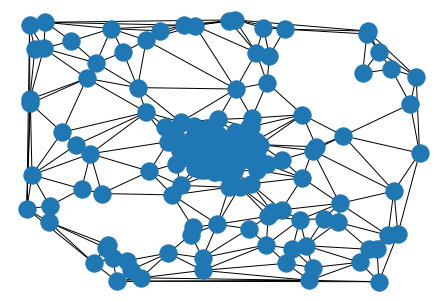

In [20]:
nx.draw(graph,pos=points)

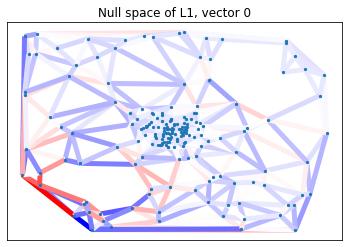

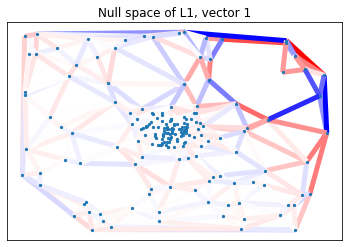

In [21]:
np.random.seed(0)

t_max = 100
n_t = 100
labels = dict(((u, v), d) for d, (u, v) in enumerate(graph.edges))


Null_Space_Plot(graph,save=True,folder='./plots/')


initial_phase = np.random.uniform(0, 2 * np.pi, len(graph.edges))
complex_delaunay = SimplicialComplex(graph=graph, no_faces=False)
KerL1=sc.linalg.null_space(complex_delaunay.L1.todense())


In [22]:
grad_subspace, curl_subspace, harm_subspace = get_subspaces(complex_delaunay)




In [23]:
edge_result = integrate_edge_kuramoto(complex_delaunay, initial_phase, t_max, n_t, alpha_1=1, alpha_2=0)
